## This notebook loads the data of outward runs and finds the significant spatially informaive cells/clusters. 

In [412]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from scipy.ndimage import gaussian_filter1d
from scipy.special import factorial
from scipy.stats import spearmanr
import pftools as pf
import configparser
import os
import matplotlib as mpl
# Initialize the configuration parser
# config = configparser.ConfigParser()

# # Read the configuration file
# config.read('config.ini')

# # Get the data folder path from the config file
# savefolder= config['paths']['savefolder']
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 16  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 16  # You can adjust the font size as needed
import mtools as mot
import pickle

In [413]:
from pathlib import Path
# Detect base directory
try:
    BASE_DIR = Path(__file__).resolve().parent  # For scripts
except NameError:
    BASE_DIR = Path.cwd()  # For Jupyter Notebooks

# Move one level up
BASE_DIR = BASE_DIR.parent

# Load config.ini
config = configparser.ConfigParser()
config.read(os.path.join(os.getcwd(), "config.ini"))

# Construct full paths using pathlib and ensure they end with a separator
skeletonsfolder = str((BASE_DIR / config["paths"]["skeletonsfolder"]).resolve()) + os.sep
savefolder = str((BASE_DIR / config["paths"]["savefolder"]).resolve()) + os.sep
datafolder = str((BASE_DIR / config["paths"]["datafolder"]).resolve()) + os.sep

# Print paths to verify
print("Base Directory:", BASE_DIR)
print("Skeletons Folder:", skeletonsfolder)
print("Save Folder:", savefolder)
print("Data Folder:", datafolder)

Base Directory: c:\Users\hamed\Desktop\Hamed\Github\TP7
Skeletons Folder: C:\Users\hamed\Desktop\Hamed\Github\TP7\data\GCaMP6f_478-485\skeleton\
Save Folder: C:\Users\hamed\Desktop\Hamed\Github\TP7\results_new\
Data Folder: C:\Users\hamed\Desktop\Hamed\Github\TP7\data\GCaMP6f_478-485\


In [414]:

plt.rcParams['svg.fonttype'] = 'none'  # Export text as SVG <text> objects, not paths

mpl.rcParams['xtick.major.size'] = 6    # Length of major ticks on x-axis
mpl.rcParams['xtick.major.width'] = 1.5 # Width of major ticks on x-axis
mpl.rcParams['xtick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['xtick.major.pad'] = 10    # Padding between ticks and x-axis labels

mpl.rcParams['ytick.major.size'] = 6    # Length of major ticks on y-axis
mpl.rcParams['ytick.major.width'] = 1.5 # Width of major ticks on y-axis
mpl.rcParams['ytick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['ytick.major.pad'] = 10    # Padding between ticks and y-axis labels


# Set default spine and tick settings globally for all plots
mpl.rcParams['axes.linewidth'] = 1.5     # Set the width of all spines (top, bottom, left, right)
mpl.rcParams['xtick.major.width'] = 1.5  # Width of major ticks on x-axis
mpl.rcParams['ytick.major.width'] = 1.5  # Width of major ticks on y-axis
mpl.rcParams['xtick.labelsize'] = 12     # Font size of x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12     # Font size of y-axis tick labels

# Define the helper function to hide spines
def hide_spines(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [415]:
def computeSpatialInfo_matrix(r_all, P_x, epsilon=1e-10):
    r_all = np.asarray(r_all, float)
    P_x = np.asarray(P_x, float)

    # broadcast mask
    mask = np.isfinite(r_all) & np.isfinite(P_x[None, :])
    r_all = np.where(mask, np.clip(r_all, 0, None), np.nan)
    P = np.where(mask, P_x, np.nan)

    r_0 = np.nansum(P * r_all, axis=1) / np.nansum(P, axis=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        I = np.nansum(P * r_all * np.log2((r_all + epsilon) / (r_0[:, None] + epsilon)), axis=1)
    return I


In [416]:
import numpy as np

def computeSpatialInfo(r_x, P_x, r_0=None, epsilon=1e-10):
    """
    Spatial information per second. NaNs/Infs in r_x or P_x are ignored.
    """
    r_x = np.asarray(r_x, float)
    P_x = np.asarray(P_x, float)

    # valid bins only
    mask = np.isfinite(r_x) & np.isfinite(P_x)
    if not mask.any():
        return np.nan

    r_x = np.clip(r_x[mask], 0, None)
    P_x = np.clip(P_x[mask], 0, None)

    # compute r_0 over the same valid bins if not given or invalid
    if r_0 is None or not np.isfinite(r_0):
        r_0 = np.sum(P_x * r_x) / np.sum(P_x)

    with np.errstate(divide='ignore', invalid='ignore'):
        I = np.sum(P_x * r_x * np.log2((r_x + epsilon) / (r_0 + epsilon)))

    return I


In [417]:

def compute_allinfo(all_rates,P_x,r0,num_neurons):
    all_I_f = np.zeros(num_neurons)  # Forward I

    for nid in range(num_neurons):
  
        all_I_f[nid] = computeSpatialInfo(all_rates[nid, :], P_x, r0[nid])
    return(all_I_f)

In [418]:
phase='learning'
chosen_cell_type='all'


In [419]:
# load the data from outward runs and find place cells.
#burst_len='200ms'
fol='485'
dir_of_run='R'
#celltype='PC'
celltype='Alltest_neworder'
fs = 20# sampling freq
burst_length=0.5
burst_len=str(burst_length)+'s'
burstsize=burst_length*fs# sample numbers of a burst

shuffle_number=200# 

In [420]:
savefolder

'C:\\Users\\hamed\\Desktop\\Hamed\\Github\\TP7\\results_new\\'

In [421]:
#filename = fol+'outward_'+dir_of_run+'_'+phase+'_correct_No_chunk_'+burst_len+'_transients_'+celltype+'_with_templates'
#filename = fol+'sampling_L outward_L reward_L_'+phase+'_correct_No_chunk_'+burst_len+'_transients_'+celltype+'_with_templates'# load all at once reward outward sampling

filename = fol+'outward_'+dir_of_run+'_'+phase+'_correct'# Analyze place code with data of outward runs

filename=fol+'_arena_outward_'+dir_of_run+'_No_chunk_0.5s_transients_All.pkl'
#filename_sampling = fol+'sampling_'+dir_of_run+'_'+phase+'_correct_No_chunk_'+burst_len+'_transients_'+celltype+'_with_templates'

#filename = '478outward_R_all_correct_all_days_randomized_bursts_200ms_transients_allnew'

data = np.load(join(savefolder, filename), allow_pickle=True)
#data_reward = np.load(join(savefolder, filename_reward), allow_pickle=True)
#data_sampling = np.load(join(savefolder, filename_sampling), allow_pickle=True)

bound = [0, data['lin_pos'].shape[0]] #if turn_type == 'left' else [sepidx, endind]  

target_cluids=np.unique(data['ids_clust'])

In [422]:
filename=filename[:-4]

In [423]:
y, neuron_tspidx, burst_tidxs, burst_cluids, num_neurons, dt = pf.GetData(data, bound=bound)


In [424]:
#burst_tidxs_reward=data_reward['spike_idx'][0]
#burst_tidxs_sampling=data_sampling['spike_idx'][0]

In [425]:
len(y)

1933

In [426]:
conds=['sampling_L',
 'sampling_R',
 'outward_L',
 'outward_R',
 'reward_L',
 'reward_R',
 'inward_L',
 'inward_R']




cond_number = dict(zip(conds, np.arange(len(conds))))# make mask values for each task
cond_names=cond_number

In [427]:
cond_names = {
 'arena_outward_L': 8,
 'arena_outward_R': 9,
 'arena_inward_L': 10,
 'arena_inward_R': 11
}


In [428]:
# run_data={'idpeaks_cells':[[] for _ in range(len(sess_info['Spike_times_cells']))]}
# run_data['idpeaks']=np.asarray(sess_info['id_peaks'])
# t_all=np.asarray(sess_info['t'])
# spk_times=np.where(np.isin(t_all,run_data['idpeaks']))# time of spike for population rate in the determined condtions

In [429]:
import numpy as np

In [430]:

# cell_types='All'
# descriotor='No_chunk_0.5s_transients'
# for fol in ['478','481','483','485']:

#     #savefolder = 'C:/Users/hamed/Desktop/Hamed/Github/TP7/results/'
#     #savefolder ='C:/Users/hamed/Desktop/Hamed/BCN/sequence/results/'
#     #filename = '48520220215_gcamp6f485_task_learning.mat_all_sessions_all_days_transients'
#     #filename = fol+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_neworder'+burst_len+'_transients_'+celltype
#     #fol='481'
#     #phase='all'
#     filename = fol+'Sesseion_info_All AllNo_chunk_0.5s_transients'

#     #filename = '478outward_R_all_correct_all_days_randomized_bursts_200ms_transients_allnew'

#     data_all_tasks = np.load(join(savefolder, filename), allow_pickle=True)
#     sess_info= data_all_tasks['sess_info']
#     Masks= data_all_tasks['Masks']

#     data_info=np.load(savefolder+fol+'data_all_sessions'+cell_types+'_'+ descriotor+'newodrer', allow_pickle=True)
#     session_mask=data_info[1]







#     speed_thr=0
#     # add the mask for speed. speed threshold is set to 5.
#     smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
#     Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
#     Masks['speed']=smooth_speed>speed_thr


#     # select the data you need. Sessen number, epeoch, .... Selected data will be saved with corresposing name. Inward and outward data will be used by place filed code. 
#     sessin_numbers=np.arange(len(session_mask))#[4,5,6,7][0,1,2,3]##np.arange(len(session_mask))
#     #sessin_numbers=[6]
#     #sessin_numbers=[0,1,2,3,4,5,6,7] # soecify which session you want to work with
#     #celid=23# number of sample cell to show in the plot

#     #cond_number=[3] # conditon name (outwards)
#     #cond_number=[8,9,10,11] # inwards
#     #cond_number=[0,1] # sampling
#     #cond_number=[6,7] # reward
#     for con_number in ([0,2,4,]):
            
#         trial_type=1 # 1 is correct       0 is failed

#         if trial_type==1:
#             type_name='correct'
#         elif trial_type==0:
#             type_name='failed'



#         phase=1#None#None#,1 # 0 is learning,    1 is learned,  None is both
#         if phase==None:
#             phase_name='all'
#         elif phase==0:
#             phase_name='learning'
#         elif phase==1:
#             phase_name='learned'
                


#         # odd_even=1# even trials
#         # run_data_e=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
#         # #plt.title(run_data_e['sess_name']+' (even) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

#         # odd_even=0# odd trials
#         # run_data_o=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
#         # #plt.title(run_data_e['sess_name']+' (odd) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

#         odd_even=None# all trials
#         run_data_all=mot.apply_masks_test(sess_info,Masks,[con_number],cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)



#         reversed_mapping = {v: k for k, v in cond_names.items()}
#         print(reversed_mapping.get(con_number,'Key not found'),len(run_data_all['trace_cells']))
#         animal_direction=reversed_mapping.get(con_number,'Key not found')
#         #animal_direction = mot.find_condition(cond_number,cond_names)
#         #print(animal_direction)
#         run_data_all['template']=sess_info['template']
#         # with open(savefolder+fol+animal_direction+'_'+ phase_name+'_'+type_name+'_'+descriotor+'_'+cell_types+'test_neworder_with_templates','wb') as f:
#         #     pickle.dump(dict(run_data_all), f)   
#         #plt.title(run_data_e['sess_name']+' (all) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')
#         with open(savefolder+fol+animal_direction+'_'+ phase_name+'_'+type_name+'_'+descriotor+'_'+cell_types+'test_neworder_with_templates','wb') as f:
#             pickle.dump(dict(run_data_all), f) 
    

In [431]:
fol

'485'

In [432]:

# cell_types='All'
# descriotor='No_chunk_0.5s_transients'
# for fol in ['478','481','483','485']:

#     savefolder = 'C:/Users/hamed/Desktop/Hamed/Github/TP7/results/'
#     #savefolder ='C:/Users/hamed/Desktop/Hamed/BCN/sequence/results/'
#     #filename = '48520220215_gcamp6f485_task_learning.mat_all_sessions_all_days_transients'
#     #filename = fol+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_neworder'+burst_len+'_transients_'+celltype
#     #fol='481'
#     #phase='all'
#     filename = fol+'Sesseion_info_All AllNo_chunk_0.5s_transients'

#     #filename = '478outward_R_all_correct_all_days_randomized_bursts_200ms_transients_allnew'

#     data_all_tasks = np.load(join(savefolder, filename), allow_pickle=True)
#     sess_info= data_all_tasks['sess_info']
#     #Masks= data_all_tasks['Masks']# this mask does not include mask of correct trials of single cells


#     filename_mask = fol+'Mask_with_correct_cells'
#     Masks_ = np.load(join(savefolder, filename_mask), allow_pickle=True)# i added the correct masks for single cell data recently
#     Masks=Masks_[0]


#     #data_info=np.load(savefolder+fol+'data_all_sessions'+cell_types+'_'+ descriotor+'newodrer', allow_pickle=True)
#     session_mask=Masks_[1]







#     speed_thr=0
#     # add the mask for speed. speed threshold is set to 5.
#     smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
#     Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
#     Masks['speed']=smooth_speed>speed_thr


#     # select the data you need. Sessen number, epeoch, .... Selected data will be saved with corresposing name. Inward and outward data will be used by place filed code. 
#     sessin_numbers=np.arange(len(session_mask))#[4,5,6,7][0,1,2,3]##np.arange(len(session_mask))
#     #sessin_numbers=[6]
#     #sessin_numbers=[0,1,2,3,4,5,6,7] # soecify which session you want to work with
#     #celid=23# number of sample cell to show in the plot

#     #cond_number=[3] # conditon name (outwards)
#     #cond_number=[8,9,10,11] # inwards
#     #cond_number=[0,1] # sampling
#     #cond_number=[6,7] # reward
#     for con_number in ([0,2,4],[1,3,5]):
            
#         trial_type=1 # 1 is correct       0 is failed

#         if trial_type==1:
#             type_name='correct'
#         elif trial_type==0:
#             type_name='failed'



#         phase=0#None#None#,1 # 0 is learning,    1 is learned,  None is both
#         if phase==None:
#             phase_name='all'
#         elif phase==0:
#             phase_name='learning'
#         elif phase==1:
#             phase_name='learned'
                


#         # odd_even=1# even trials
#         # run_data_e=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
#         # #plt.title(run_data_e['sess_name']+' (even) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

#         # odd_even=0# odd trials
#         # run_data_o=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
#         # #plt.title(run_data_e['sess_name']+' (odd) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

#         odd_even=None# all trials
#         run_data_all=mot.apply_masks_test(sess_info,Masks,con_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)



#         name_of_conds=' '.join([xn for xn,x in cond_names.items() if x in con_number])

#         run_data_all['template']=sess_info['template']

#         # with open(savefolder+fol+name_of_conds+'_'+ phase_name+'_'+type_name+'_'+descriotor+'_'+cell_types+'test_neworder_with_templates','wb') as f:
#         #     pickle.dump(dict(run_data_all), f) 
    

In [433]:
# run_data_out=run_data
# t_all_out_out=t_all_out
# mask_cond_t_out=mask_cond_t




In [434]:
# run_data_sam=run_data
# t_all_out_sam=t_all_out
# mask_cond_t_sam=mask_cond_t



In [435]:
# Analysis parameters
exclude_peak_neighs=1
include_peak_neighs=0


dt = 1/fs  # bin size of each time index
dy = 0.001 # bin size for position histogram. Since we will smooth the histogram anyways, the smaller the better (approaching Kernel Density Estimation).
sigma_y = 0.05 # I do not know the size of the animal. So, assume it to be 1% of the track.
sigma_yidx = sigma_y/dy  # Convert the position unit to unit of array index.
yedges = np.arange(0-dy/2, 1+dy, dy)  # edges for histogram
y_ax = pf.MidAx(yedges)  # position axis, mainly for plotting. Since edges are just for histogram.

# Creating a mask array for excluding position bins at the burst events (with neighbouring number of index = 1)
expanded_all_burst_tidxs = pf.expand_neighbins(burst_tidxs, expand_neighs=exclude_peak_neighs)

y_tax = np.arange(y.shape[0])
y_tax_excluded = pf.exclude_idx(y_tax, expanded_all_burst_tidxs)
y_excluded = y[y_tax_excluded]


# Compute the occupancy, using only those admitted position points
occ, occ_gau = pf.GetOccupancy(y_excluded, yedges, dt, sigma_yidx)

In [436]:
#occ_gau=occ_gau+1e-10

In [437]:
len(y)

1933

In [438]:
r_all,counts_all,p_all= pf.get_rate_all(data,neuron_tspidx,occ_gau,yedges,sigma_yidx,expanded_all_burst_tidxs,num_neurons,y,y_ax,shuffle_spikes=False)

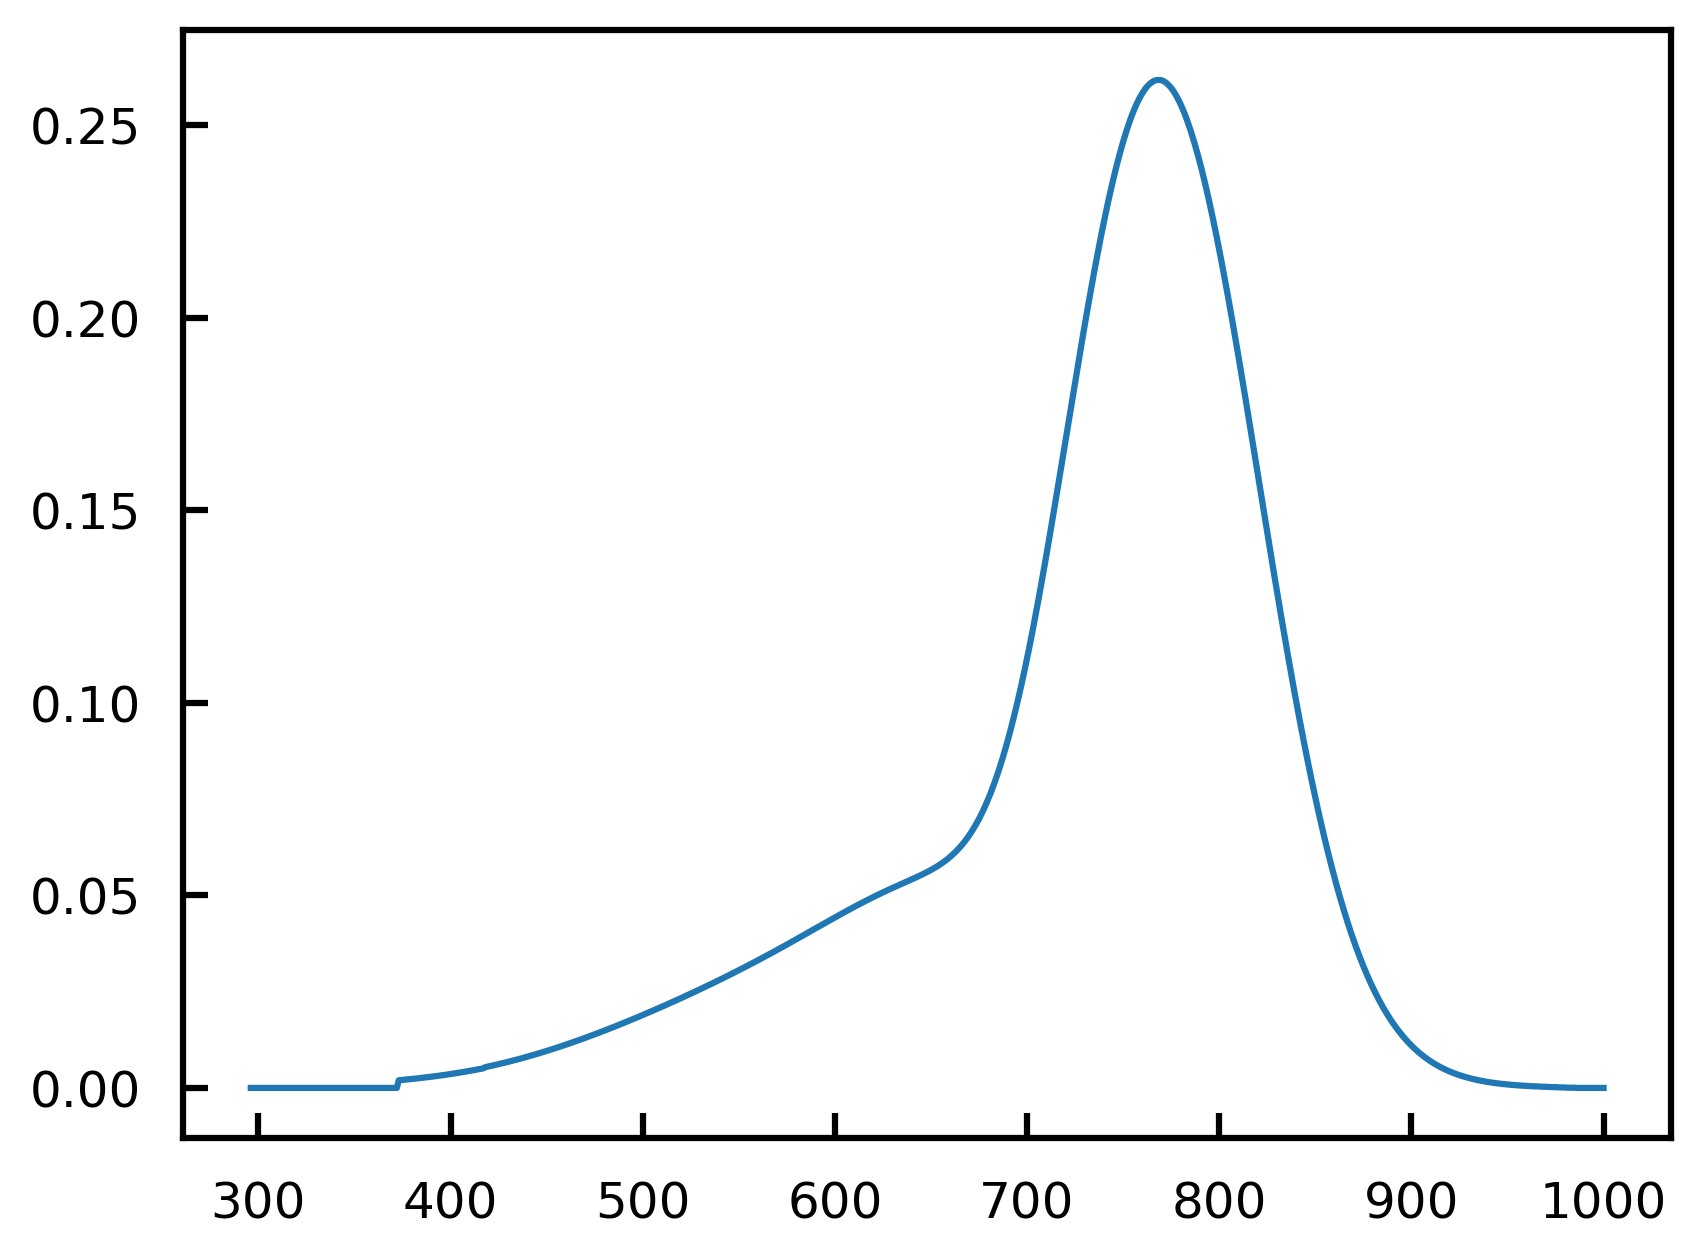

In [439]:
plt.plot(r_all[0])

In [440]:
# ## remove NaN columns

# cols_ok = ~np.isnan(r_all).any(axis=0)   # keep these 1001 cols
# r_all_clean = r_all[:, cols_ok]

# r_all= r_all_clean

In [441]:

r_shuffled_cells_all=[]
pvals=np.zeros(num_neurons)

for sh in range(shuffle_number):

    p_all_sh=np.zeros_like(p_all)
    counts_all_sh=np.zeros_like(counts_all)
    r_all_sh=np.zeros_like(r_all)

    spikes=[]
    spikes_sh=[]

    r_all_sh,counts_all_sh,p_all_sh= pf.get_rate_all(data,neuron_tspidx,occ_gau,yedges,sigma_yidx,expanded_all_burst_tidxs,num_neurons,y,y_ax,shuffle_spikes=True)

    r_shuffled_cells_all.append(r_all_sh)


    r0 = pf.mean_rate2(r_all, p_all,num_neurons)
    all_I=compute_allinfo(r_all,p_all,r0[0],num_neurons)

    r0_sh = pf.mean_rate2(r_all_sh, p_all_sh,num_neurons)
    all_I_sh=compute_allinfo(r_all_sh,p_all_sh,r0_sh[0],num_neurons)


    pvals+=all_I>all_I_sh

    
pf_pvals=1-pvals/shuffle_number    









In [442]:
all_I

array([0.04399385, 0.01420604, 0.04018968, 0.01606102, 0.02502298,
       0.        , 0.02728566, 0.10396267, 0.        , 0.        ,
       0.03570607, 0.27259634, 0.        , 0.01093965, 0.01483823,
       0.03954036, 0.04676701, 0.0102785 , 0.0154987 , 0.        ,
       0.02935332, 0.02685073, 0.0190757 , 0.        , 0.01860998,
       0.07261333, 0.02845207, 0.        , 0.13250039, 0.02624556,
       0.        , 0.00722561, 0.04489777, 0.        , 0.        ,
       0.01875847, 0.01023816, 0.06379538, 0.06483783, 0.0151225 ,
       0.03725512, 0.03519984, 0.09270305, 0.10396764, 0.        ,
       0.01590424, 0.        , 0.01053018, 0.        , 0.02351919,
       0.03721329, 0.03218118, 0.04041044, 0.01411973, 0.0131528 ,
       0.01309602, 0.        , 0.01514118, 0.01723652, 0.06676468,
       0.0169935 , 0.02728626, 0.11777912, 0.1040574 , 0.05764711,
       0.00291928, 0.00813769, 0.04381664, 0.        , 0.24437934,
       0.        , 0.01156045, 0.01993065, 0.02164655, 0.01007

In [443]:
trajtidx = np.arange(y.shape[0])
all_L_norm = np.zeros((y_ax.shape[0], trajtidx.shape[0]))


# Loop through all time indexes to decode the positions.
# Looping each time index is not so efficient. Vectorization is recommended if you do not need to include the neighbouring bins for decoding.
for trajtidx_each in trajtidx:
    print('\r%d/%d'%(trajtidx_each, trajtidx.shape[0]), end="", flush=True)
    
    # Decode each time index. 
    _, L_norm = pf.decode_neighbins(trajtidx_each, y_ax, r_all, neuron_tspidx, dt=dt, num_neigh=include_peak_neighs)
    all_L_norm[:, trajtidx_each] = L_norm

1932/1933

In [444]:
sign=pf_pvals<.05
insign=pf_pvals>=.05

place_cell_data={}
place_cell_data['rate_all']=r_all
place_cell_data['rate_all_shuffled']=r_shuffled_cells_all


place_cell_data['significant']=sign
place_cell_data['pvalues']=pf_pvals
place_cell_data['insignificant']=insign

place_cell_data['all_L_norm']=all_L_norm

In [445]:
all_L_norm.shape

(1001, 1933)

In [446]:
from scipy.stats import mode
# Take the maximum of posterior probabilities across the position as the prediction 
# It is the maximum likelihood (ML) estimator.
yidx_max = np.nanargmax(all_L_norm, axis=0)
y_ML = y_ax[yidx_max]
# Identify the position bin that is the bias, to be excluded

biased_y = mode(y_ML)
#print('The biased y estimator value is ', biased_y, '\nPlease make sure the value corresponds to the most overrepresented ML estimator in the trajectory decoding above.')
#biased_yidx = np.where(y_ax == biased_y.mode[0])[0][0]
#print('The index of the position bin corresponding to this biased value \n =', biased_yidx)

In [447]:
biased_yidx = np.where(y_ax == biased_y.mode)[0][0]

In [448]:
# only get the cluster that has at least 3 burst
thr_burst_number=4
target_cluids_long=[]
for cid,target_cluid in enumerate(target_cluids):
    
    # Select the burst events that belong to this cluster id
    clu_idxs = np.where(burst_cluids == target_cluid)[0]
    num_clu_bursts = len(clu_idxs)
    burst_tidx = burst_tidxs[clu_idxs]
    #print(len(burst_tidx))
    if len(burst_tidx)>thr_burst_number:
        target_cluids_long.append(target_cluid)
target_cluids_long= np.array(target_cluids_long)


In [449]:
expanded_all_burst_tidxs = pf.expand_neighbins(burst_tidxs, expand_neighs=exclude_peak_neighs)
expanded_all_burst_tidxs=[]
num_clusters=len(target_cluids_long)
target_cluids_long
r_all_cluster,counts_all_cluster,p_all_cluster= pf.get_rate_all_clusters(data,target_cluids_long,y,occ_gau,yedges,sigma_yidx,expanded_all_burst_tidxs,num_neurons,y_ax,burst_tidxs,burst_cluids,shuffle_spikes=False)

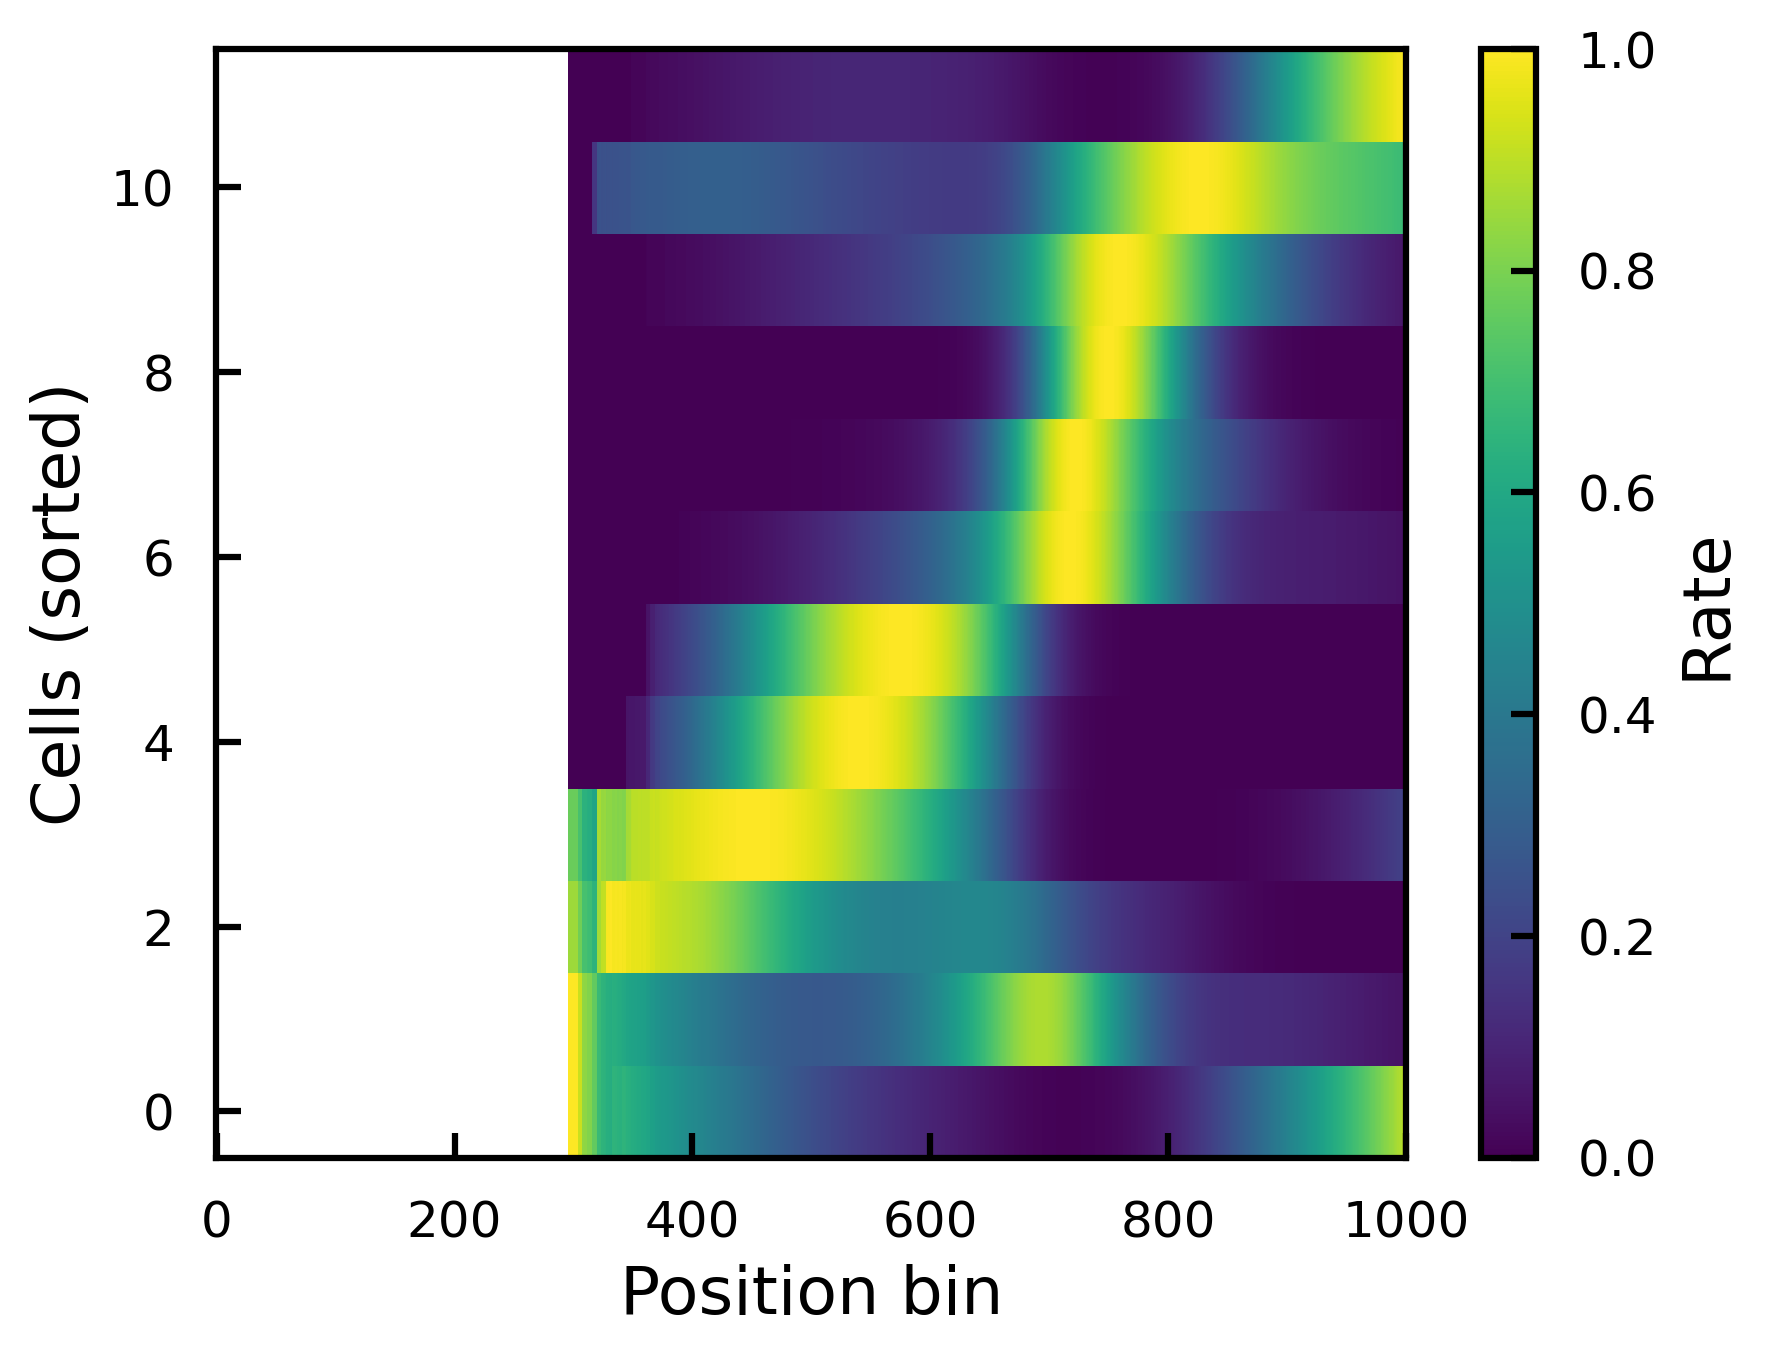

In [450]:
# r_all:  (n_cells × n_posbins) firing-rate matrix
# sign :  indices or boolean mask for the cells you want to plot

idx = np.asarray(sign)                         # make sure it's an index array
rates = r_all[idx, :]                          # subset

# --- choose one of these metrics ---
# 1) Peak bin (simple and common)
peak_bin = np.nanargmax(rates, axis=1)

# 2) Center of mass (robust if fields are broad)
pos_axis = np.arange(rates.shape[1])
com = np.sum(rates * pos_axis, axis=1) / np.maximum(rates.sum(axis=1), 1e-9)

# pick which to use:
metric = peak_bin   # or com

# handle silent cells (all zeros) → push to bottom
silent = rates.max(axis=1) <= 0
metric[silent] = 0

# sort rows
order = np.argsort(metric)
rates_sorted = rates[order, :]

# keep track of original cell IDs if needed
sorted_cells = idx[order]
norm = rates_sorted / np.nanmax(rates_sorted, axis=1, keepdims=True)

# plot
plt.imshow(norm,
           aspect='auto', origin='lower', interpolation='none', cmap='viridis')
plt.xlabel('Position bin')
plt.ylabel('Cells (sorted)')
plt.colorbar(label='Rate')
plt.show()


In [451]:
# Compute place field of clusters

num_clusters=len(target_cluids_long)
pvals_cluster=np.zeros(num_clusters)
rate_shuffled_all=[]
for sh in range(shuffle_number):


    p_all_sh=np.zeros_like(p_all)
    counts_all_sh=np.zeros_like(counts_all)
    r_all_sh=np.zeros_like(r_all)

    spikes=[]
    spikes_sh=[]


    expanded_all_burst_tidxs = pf.expand_neighbins(burst_tidxs, expand_neighs=exclude_peak_neighs)
    expanded_all_burst_tidxs=[]
    #r_all_cluster = np.zeros((num_clusters, y_ax.shape[0])).astype(float)  # for storing firing rates

    r_all_cluster_sh,counts_all_cluster_sh,p_all_cluster_sh= pf.get_rate_all_clusters(data,target_cluids_long,y,occ_gau,yedges,sigma_yidx,expanded_all_burst_tidxs,num_neurons,y_ax,burst_tidxs,burst_cluids,shuffle_spikes=True)


    rate_shuffled_all.append(r_all_cluster_sh)

    r0 = pf.mean_rate2(r_all_cluster, p_all_cluster,num_clusters)
    all_I=compute_allinfo(r_all_cluster,p_all_cluster,r0[0],num_clusters)


    r0_sh = pf.mean_rate2(r_all_cluster_sh, p_all_cluster_sh,num_clusters)
    all_I_sh=compute_allinfo(r_all_cluster_sh,p_all_cluster_sh,r0_sh[0],num_clusters)


    pvals_cluster+= all_I>all_I_sh
pf_pvals_clusters=1-pvals_cluster/shuffle_number    
# Plot place fields as a heatmap
# fig, (ax,ax2) = plt.subplots(1, 2,figsize=(8, 4))

# im = ax.pcolormesh(y_ax, np.arange(num_clusters), r_all_cluster)
# ax.set_yticks(np.arange(num_clusters))
# ax.set_yticklabels(target_cluids_long)

# plt.colorbar(im, ax=ax)
# plt.title('original ')

# plt.subplot(122)
# #fig, ax = plt.subplots(figsize=(16, 8))
# im = ax2.pcolormesh(y_ax, np.arange(num_clusters), r_all_cluster_sh)
# ax2.set_yticks(np.arange(num_clusters))
# ax2.set_yticklabels(target_cluids_long)

# plt.colorbar(im, ax=ax2)
# plt.title('shuffled ')

In [452]:
import pickle
sign=pf_pvals_clusters<.05
insign=pf_pvals_clusters>=.05
significant_Clusters={}
significant_Clusters['singnificnts_cluster_ids']=target_cluids_long[sign]
significant_Clusters['insingnificnts_cluster_ids']=target_cluids_long[insign]
significant_Clusters['significant_ratio']=np.sum(sign)/len(sign)
significant_Clusters['pvalues']=pf_pvals_clusters
significant_Clusters['cluster_numbers']=target_cluids_long
significant_Clusters['rate_significant']=r_all_cluster[sign]
significant_Clusters['rate_insignificant']=r_all_cluster[insign]
significant_Clusters['rate_all_clusters']=r_all_cluster
significant_Clusters['rate_shuffled_clusters']=rate_shuffled_all
#significant_Clusters['replay_insignificant']=significant_bursts
significant_Clusters['burst_tidxs']=burst_tidxs


significant_cluster_name = savefolder+filename+'_Cluster'



# # Save the significant_Clusters
with open(significant_cluster_name, 'wb') as file:
    pickle.dump(significant_Clusters, file)

# Save the rate maps of cells and clusters
place_cell_data['Clusters']=significant_Clusters
place_cell_data_name = savefolder+filename+'_Cell'

# # Save the boolean vector to a file
with open(place_cell_data_name, 'wb') as file:
    pickle.dump(place_cell_data, file)

In [453]:
sdfsdfsdfdf

NameError: name 'sdfsdfsdfdf' is not defined

In [454]:
place_cell_data_name

'C:\\Users\\hamed\\Desktop\\Hamed\\Github\\TP7\\results_new\\485_arena_outward_R_No_chunk_0.5s_transients_All_Cell'

In [ ]:
filename

'485_arena_outward_L_No_chunk_0.5s_transients_All.pkl'

In [ ]:
boz

NameError: name 'boz' is not defined

In [ ]:
import numpy as np

print(np.__version__)



1.23.5


In [ ]:
dfg

In [ ]:
fol1='485'#fol#'478'
phases=['learning','learned']
direction=['L','R']
PC_phase_data={}
PCclstr_phase_data={}

sessinfo_and_mask=np.load(savefolder+fol1+'Sesseion_info_All AllNo_chunk_0.5s_transients',allow_pickle=True)


#sessinfo_and_mask=np.load(savefolder+fol1+'Sesseion_info_Arena',allow_pickle=True)




for phase in phases:
    PC_dir_data={}
    PClstr_dir_data={}

    for dir in direction:
        #cluster_pc_fractions=np.load(savefolder+fol1+'outward_'+dir+'_'+phase+'_correct_No_chunk_0.5s_transients_Alltest_neworder_with_templates_place_cell_data'+chosen_cell_type,allow_pickle=True)
        PC_dir_data[dir]=np.load(savefolder+fol1+'outward_'+dir+'_'+phase+'_correct_Cell',allow_pickle=True)
        PClstr_dir_data[dir]=np.load(savefolder+fol1+'outward_'+dir+'_'+phase+'_correct_Cluster',allow_pickle=True)

    PC_phase_data[phase]=PC_dir_data
    PCclstr_phase_data[phase]=PClstr_dir_data


sessinfo_and_mask['place_cells_data']=PC_phase_data
sessinfo_and_mask['place_cluster_data']=PCclstr_phase_data



with open(savefolder+fol1+'Sesseion_info_arena'+'_with_PC','wb') as f:
    pickle.dump(sessinfo_and_mask, f) 

In [ ]:
sdfsdf

In [ ]:
significant_Clusters['cluster_numbers']

array([], dtype=float64)

In [ ]:
# Visualizing the place code of bursts in each cluster id (membership)
plt.rcParams.update({'font.size': 18})
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 18  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 18 # You can adjust the font size as needed

# Loop through all the cluster ids
for target_cluid in significant_Clusters['cluster_numbers']:# only shows clusters with minimum 5 events in them
    
    # Select the burst events that belong to this cluster id
    clu_idxs = np.where(burst_cluids == target_cluid)[0]
    num_clu_bursts = len(clu_idxs)
    
    # Decode each burst event with its 2 neighbouring bins
    num_neigh =1
    all_L_norm = np.zeros((y_ax.shape[0], num_clu_bursts))
    
    # loop through all burst events that belong to this cluster id
    # and decode the posterior prob
    for i in range(num_clu_bursts):
        clu_idx = clu_idxs[i]
        burst_tidx = burst_tidxs[clu_idx]
        _, L_norm = pf.decode_neighbins(burst_tidx, y_ax, r_all, neuron_tspidx, dt=0.05, num_neigh=num_neigh)
        all_L_norm[:, i] = L_norm

    # Take the maximum as the prediction
    yidx_max = np.argmax(all_L_norm, axis=0)
    y_ML = y_ax[yidx_max]

    # Obtain the real positions
    bursttidx_clu = burst_tidxs[clu_idxs]
    y_real = y[bursttidx_clu]
    
    # Sort the real positions from low to high.
    sort_idx = np.argsort(y_real)
            
    # Burst id axis, for plotting purpose.
    burst_id_ax = np.arange(num_clu_bursts)
    
    
    # Plot the posterior heatmap
    fig, ax = plt.subplots(1, 1, figsize=(8, 4), )
    im = ax.pcolormesh(burst_id_ax, y_ax, all_L_norm[:, sort_idx])
    plt.colorbar(im, ax=ax)
    
    # Plot the real and ML positions. Using the sorting index comptued before.
    ax.scatter(burst_id_ax, y_ML[sort_idx], color='r', marker='x', s=50, label='ML')  # ML estimators
    ax.scatter(burst_id_ax, y_real[sort_idx], color='b', marker='x', s=50, label='Real')  # Real positions
    
    ax.set_xlabel("Burst event id sorted by real position",fontsize=18)
    ax.set_ylabel('Position',fontsize=18)
    #ax.legend(loc='lower right')
    if target_cluid in significant_Clusters['singnificnts_cluster_ids']:
        ax.set_title(' Decoded posterior for SI cluster %d '%(target_cluid)+' '+burst_len)
    else:
        ax.set_title(' Decoded posterior for Non-SI cluster %d '%(target_cluid)+' '+burst_len)
    
    # Plot the marginal sum of posterior probability 
    # separately for bursts occurring when the animal is at the middle stem or the arm.
    # ax[1].plot(y_ax, all_L_norm[:, (y_real>=0) & (y_real < 0.5)].sum(axis=1), label='Mid')
    # ax[1].plot(y_ax, all_L_norm[:, (y_real>=0.5)].sum(axis=1), label='Arm')

    # #ax[1].scatter(all_L_norm[:, (y_real>=0) & (y_real < 0.5)].sum(axis=1), all_L_norm[:, (y_real>=0.5)].sum(axis=1), label='Arm vs mid')

    # ax[1].set_xlabel('Position')
    # ax[1].set_title('Marginal sum of posterior across all bursts, when the real position is in MidStem or Arm')
    # ax[1].legend()
    
    fig.tight_layout()
    #fig.savefig(join(savefolder, '%s_ClusterPlaceCode-Clu-.png'%(target_cluid)), dpi=300, facecolor='w')
    
    fig.savefig(savefolder+'_ClusterPlaceCode-Clu'+str(target_cluid)+filename+burst_len+celltype+burst_len+'.png', facecolor='w')